In [1]:
import torch
import numpy as np

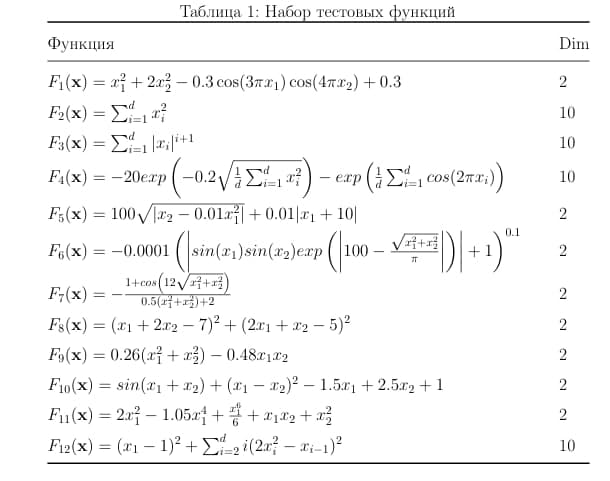

In [2]:
def F1(X):
    x1, x2 = X
    f = x1**2 + 2*x2**2 - 0.3*torch.cos(3*np.pi*x1)*torch.cos(4*np.pi*x2) + 0.3
    return f
def F2(X):
    return torch.pow(X, 2).sum(axis=1)
def F3(X):
    s = torch.zeros(X.shape[0])
    for i in range(X.shape[1]):
        s += torch.pow(torch.abs(X[:, i]), i+1)
    return s
def F4(X):
    f = -20*torch.exp(-0.2*torch.sqrt(1/X.shape[1]*torch.pow(X,2).sum(axis=1))) 
    f -= torch.exp(1/X.shape[1]*torch.cos(2*np.pi*X).sum(axis=1))
    return f
def F5(X):
    x1, x2 = X
    f = 100*torch.sqrt(torch.abs(x2-0.01*x1**2)) + 0.01*torch.abs(x1+10)
    return f
def F6(X):
    x1, x2 = X
    f = -0.0001*(torch.abs(torch.sin(x1)*torch.sin(x2)*torch.exp(torch.abs(100-torch.sqrt(x1**2+x2**2)/np.pi)))+1)**0.1
    return f
def F7(X):
    x1, x2 = X
    f = - (1+torch.cos(12*torch.sqrt(x1**2+x2**2)))/(0.5*(x1**2+x2**2+2))
    return f
def F8(X):
    x1, x2 = X
    f = (x1+2*x2-7)**2 + (2*x1+x2-5)**2
    return f
def F9(X):
    f = 0.26*(x1**2+x2**2)-0.48*x1*x2
    return f
def F10(X):
    f = torch.sin(x1+x2)+(x1-x2)**2-1.5*x1+2.5*x2+1
    return f
def F11(X):
    x1, x2 = X
    f = 2*x1**2-1.05*x1**4+x**6/6+x1*x2+x2**2
    return f
def F12(X):
    assert X.shape <= (1, 1)
    f = (X[0]-1)**2
    for i in range(X.shape[1]):
        f += i*(2*X[:, i]**2 - X[:, i-1])**2 
    return f

In [22]:
func2_list = [
    F1, F5, F6, F7,
    F8, F9, F10, F11,
]

In [3]:
funcs_list = [
    F1, F2, F3, F4,
    F5, F6, F7, F8,
    F8, F10, F11, F12,
             ]

In [24]:
from pytorch_optimizer.examples.viz_optimizers import execute_experiments, execute_steps
import torch_optimizer as optim

In [25]:
def LookaheadYogi(*a, **kw):
    base = optim.Yogi(*a, **kw)
    return optim.Lookahead(base)
optimizers = [
        # baselines
        (torch.optim.Adam, -8, 0.5),
        (torch.optim.SGD, -8, -1.0),
        # Adam based
        (optim.AdaBound, -8, 0.3),
        (optim.AdaMod, -8, 0.2),
        (optim.AdamP, -8, 0.2),
        (optim.DiffGrad, -8, 0.4),
        (optim.Lamb, -8, -2.9),
        (optim.NovoGrad, -8, -1.7),
        (optim.RAdam, -8, 0.5),
        (optim.Yogi, -8, 0.1),
        # SGD/Momentum based
        (optim.AccSGD, -8, -1.4),
        (optim.SGDW, -8, -1.5),
        (optim.SGDP, -8, -1.5),
        (optim.PID, -8, -1.0),
        (optim.QHM, -6, -0.2),
        (optim.QHAdam, -8, 0.1),
        (optim.Ranger, -8, 0.1),
        (optim.RangerQH, -8, 0.1),
        (optim.RangerVA, -8, 0.1),
        (optim.Shampoo, -8, 0.1),
        (LookaheadYogi, -8, 0.1),
        (optim.AggMo, -8, -1.5),
        (optim.SWATS, -8, -1.5),
        (optim.Adafactor, -8, 0.5),
        (optim.A2GradUni, -8, 0.1),
        (optim.A2GradInc, -8, 0.1),
        (optim.A2GradExp, -8, 0.1),
        (optim.AdaBelief, -8, 0.1),
        (optim.Apollo, -8, 0.1),
    ]
    

In [26]:
def objective_F(params, F):
    lr = params['lr']
    optimizer_class = params['optimizer_class']
    initial_state = (-2.0, 3.5)
    minimum = (0, 0)
    optimizer_config = dict(lr=lr)
    num_iter = 100
    steps = execute_steps(
        F, initial_state, optimizer_class, optimizer_config, num_iter
    )
    return (steps[0][-1] - minimum[0]) ** 2 + (steps[1][-1] - minimum[1]) ** 2


In [28]:
for func in funcs_list:
    def objective_F(params):
        lr = params['lr']
        optimizer_class = params['optimizer_class']
        initial_state = (-2.0, 3.5)
        minimum = (0, 0)
        optimizer_config = dict(lr=lr)
        num_iter = 100
        steps = execute_steps(
            func, initial_state, optimizer_class, optimizer_config, num_iter
        )
        return (steps[0][-1] - minimum[0]) ** 2 + (steps[1][-1] - minimum[1]) ** 2
    def plot_F(grad_iter, optimizer_name, lr):
        x = np.linspace(-10, 10, 250)
        y = np.linspace(-10, 10, 250)
        minimum = (0, 0)

        X, Y = np.meshgrid(x, y)
        Z = func([X, Y])

        iter_x, iter_y = grad_iter[0, :], grad_iter[1, :]

        fig = plt.figure(figsize=(8, 8))

        ax = fig.add_subplot(1, 1, 1)
        ax.contour(X, Y, Z, 20, cmap='jet')
        ax.plot(iter_x, iter_y, color='r', marker='x')
        ax.set_title(
            'func: {} with '
            '{} iterations, lr={:.6}'.format(optimizer_name, len(iter_x), lr)
        )
        plt.plot(*minimum, 'gD')
        plt.plot(iter_x[-1], iter_y[-1], 'rD')
        plt.savefig('docs/rastrigin_{}.png'.format(optimizer_name))
    execute_experiments(
        optimizers,
        objective_F, #F
        func, #F TODO
        plot_F, #F TODO
        (-2.0, 3.5),
    )

100%|██████████| 200/200 [00:17<00:00, 11.36trial/s, best loss: 2.950076340909604e-06] 
0.2225780615915065 <class 'torch.optim.adam.Adam'>


TypeError: cos(): argument 'input' (position 1) must be Tensor, not numpy.ndarray